0. Introduce regressor class (sklearn compatible)
1. Predict egtm for all fleet

In [1]:
from gui.utils import *

bdu_all = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts'])

bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('reportts >= "2019-01-04"')

neo_all = pd.read_csv('./data/takeoff-merged-all-neo.csv', parse_dates=['reportts'], low_memory=False)

In [2]:
neo_all.groupby(['acnum', 'pos']).count()[['reportts']]

reportts
acnum  pos          
VP-BWB 1         254
       2         254
VP-BWM 1         279
       2         279
VP-BWN 1         201
       2         201
VQ-BCR 1         524
       2         556
VQ-BDQ 1         395
VQ-BDU 1         716
       2        1225
VQ-BGU 1         786
       2         783
VQ-BRI 1          47
       2         366

In [3]:
acms_full = pd.read_csv(
  './data/neo_takeoff_202404192324.csv', 
  parse_dates=['reportts'], 
  low_memory=False
).sort_values('reportts', ignore_index=True)

print("Total acms takeoff reports: ", acms_full.shape)

Total acms takeoff reports:  (253920, 204)


In [23]:
alpha = 0.5
alpha_2 = 0.884

baseline_degree = 2

In [15]:
def theta_correct(data, x_param, y_param, theta_param, alpha2 = alpha_2):
  mach_k = 1.0 + 0.2 * (data['mn_peak'] ** 2)
  theta = (data[theta_param] + 273.16) / (288.16 * mach_k)
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

In [33]:
from sklearn.base import BaseEstimator, RegressorMixin
import itertools
import numpy as np
from gui.utils import *

class EGTMarginRegressor(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            fleet = [],
            x_param = 'n1a_peak',
            y_param = 'egt_peak',
            theta_param = 'tat_peak',
            bleed_config = ['prv'],
            alt_config = [(0, 20_000)],
            theta_alpha = alpha_2,
            acms_data = None,
            mock_linreg = False
        ):
        self.fleet = fleet
        self.x_param = x_param
        self.y_param = y_param
        self.theta_param = theta_param
        self.bleed_config = bleed_config
        self.alt_config = alt_config
        self.theta_alpha = theta_alpha
        self.smooth_factor = 0.05
        self.acms_data = acms_data
        self.mock_linreg = mock_linreg

    def _config_to_hash (self, acnum: str, pos: int, bleed: tuple[bool], alt: tuple[int] = (0, 0)):
        if len(bleed) == 0:
            return 0
        a = map(int, bleed)
        alt_lo, alt_hi = alt
        return f'{acnum}_{pos}_' + ''.join(map(str, a)) + str(alt_lo)

    def _get_bleed_filter_index(self, X, bleed_conf: tuple[bool], alt_conf: tuple[int]):
        assert len(bleed_conf) == len(self.bleed_config)
        alt_lo, alt_hi = alt_conf
        index = (X['alt'] >= alt_lo) & (X['alt'] < alt_hi)

        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (X[field_name] == bleed_conf[i])

        return index
    
    def _find_best_acms_range(self, eng_acms, x_param, y_param):
        window = 150

        assert eng_acms.shape[0] > 300, f"Not enough acms points {eng_acms.shape}"

        for a in range(0, window * 2):
            best_r = -1000
            best_range = None
            sub = eng_acms[a:a + window].query('prv == 0')

            model = train_engine_baseline(sub, x_param, y_param, baseline_degree)
            pred = model.predict(sub[[x_param]])
            r2 = r2_score(sub[y_param],  pred)

            if r2 > best_r:
                best_r = r2
                best_range = (a, a + window) 
        
        return eng_acms[best_range[0]:best_range[1]]

    def _filter_acms_data(self, acms, bleed_conf: tuple[bool], alt_conf: tuple[int]):
        alt_lo, alt_hi = alt_conf
        index = (acms['alt'] >= alt_lo) & (acms['alt'] < alt_hi)

        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (acms[field_name] == bleed_conf[i])

        return acms[index]
    
    def _fit_single_engine(self, X, y, acnum, pos):
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'

        egt_delta = pd.DataFrame(index=X.index.copy(), columns=['base'])

        if self.acms_data is not None: 
            acms = self.acms_data \
                .query("acnum == @acnum and pos == @pos") \
                .query(f"{self.x_param} > 0 and {self.y_param} > 0 and {self.theta_param} > -100")
            
            best_acms = self._find_best_acms_range(acms)


        for bleed_comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            for alt_split in self.alt_config:
                index = self._get_bleed_filter_index(X, bleed_comb, alt_split)
                Xf, yf = X[index], y[index]

                if self.acms_data is not None: 
                    acms = self._filter_acms_data(acms, bleed_comb, alt_split)
                    acms = theta_correct(acms, self.x_param, self.y_param, self.theta_param, self.theta_alpha)

                    baseline = train_engine_baseline(best_acms, x_param_k, y_param_k, baseline_degree)
                
                else:
                    if Xf.shape[0] < 2:
                        print(f"Warning: Not enough values for baseline at {bleed_comb} {alt_split}")
                        continue
                    baseline = train_engine_baseline(Xf, x_param_k, y_param_k)

                egtm_base = compute_egtm(Xf, baseline, x_param_k, y_param_k)

                egt_delta.loc[index, 'base'] = egtm_base

                n = self._config_to_hash(acnum, pos, bleed_comb, alt_split)
                self.baselines[n] = baseline

        return egt_delta

    def _predict_single_engine(self, X, acnum, pos):
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])

        default_baseline = next(iter(self.baselines.values()))

        for bleed_comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            for alt_split in self.alt_config:
                n = self._config_to_hash(acnum, pos, bleed_comb, alt_split)
                index = self._get_bleed_filter_index(X, bleed_comb, alt_split)
                Xf = X[index]

                if n in self.baselines:
                    baseline = self.baselines[n]
                else:
                    baseline = default_baseline

                egtm = compute_egtm(Xf, baseline, x_param_k, y_param_k)

                pred_conf = self.ensemble[f'{acnum}_{pos}'].predict(egtm.to_numpy().reshape(-1, 1))
                pred.loc[index, 'pred'] = pred_conf
        
        return pred['pred']

    def fit(self, X, y):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()

        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, self.theta_alpha)
        Xk, y = Xk[X_filter], y[X_filter]

        """
        *separate* baseline for each bleed config
        later try single baseline for engine 
        but fit linreg to each bleed conf separately
        """

        self.baselines = dict()
        self.ensemble = dict()

        data = pd.concat([Xk, y], axis=1)

        grouped = data.groupby(['acnum', 'pos'])

        for group, X_engine in grouped:
            acnum, pos = group

            y_eng = X_engine['egtm']
            X_eng = X_engine.drop(columns=['egtm'])

            egt_delta = self._fit_single_engine(X_eng, y_eng, acnum, pos)

            linreg = LinearRegression()
            smooth_base_egtm = np.array(smooth(egt_delta['base'], self.smooth_factor)).reshape(-1, 1)
            
            if self.mock_linreg:
                linreg.coef_ = np.array([1.0])
                linreg.intercept_ = -10.0
            else:
                linreg.fit(smooth_base_egtm, y_eng)
            
            self.ensemble[f'{acnum}_{pos}'] = linreg

        return self
        
    def predict(self, X, smoothed=False):
        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, alpha2=self.theta_alpha)
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
        grouped = Xk.groupby(['acnum', 'pos'])

        for group, _ in grouped:
            acnum, pos = group
            index = (Xk['acnum'] == acnum) & (Xk['pos'] == pos)
            X_engine = Xk[index]
            pred_engine = self._predict_single_engine(X_engine, acnum, pos)
            if smoothed:
                pred.loc[index, 'pred'] = smooth(pred_engine, self.smooth_factor)
            else:
                pred.loc[index, 'pred'] = pred_engine

        return pred['pred']
    
    def score(self, X, y, smoothed=False):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()
        Xf, yf = X[X_filter], y[X_filter]

        y_pred = self.predict(Xf.copy(), smoothed=smoothed)
        return r2_score(yf, y_pred)

In [17]:
def take_early_cycles(X, n_start = 0, n_end = 100):
  res = []
  grouped = X.groupby(['acnum', 'pos'])

  for _, group in grouped:
    res.append(group[n_start:n_end])

  return pd.concat(res)

Need to separate A321neo from A320neo

In [25]:
x_param='n2a_peak'
y_param='egt_peak'
theta_param='tat_peak'

In [32]:
pd.DataFrame([{
  "key": k, 
  "coef": v.coef_[0], 
  "intercept": v.intercept_
} for k, v in model.ensemble.items()])

,key,coef,intercept
0,VQ-BDU_1,0.912682,-9.033006
1,VQ-BDU_2,0.199316,26.665409
2,VQ-BGU_1,1.173379,-12.170515
3,VQ-BGU_2,1.072464,-8.159486


In [41]:
a320_neo_data = neo_all \
  .query(f"(acnum != 'VQ-BGU' and acnum != 'VQ-BDU') and {x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100") \
  .copy()

model = EGTMarginRegressor(
  bleed_config=['prv'], 
  # alt_config=[(0, 3400), (3400, 20_000)],
  x_param=x_param, 
  y_param=y_param,
  theta_param=theta_param,
  
)

train = take_early_cycles(a320_neo_data, 8, 108)
X = train.drop(columns=['egtm'])
y = train['egtm']

model.fit(X, y)

r2 = model.score(a320_neo_data, a320_neo_data['egtm'], smoothed=True)

print("R2 score = ", r2)

R2 score =  0.8940130909231412


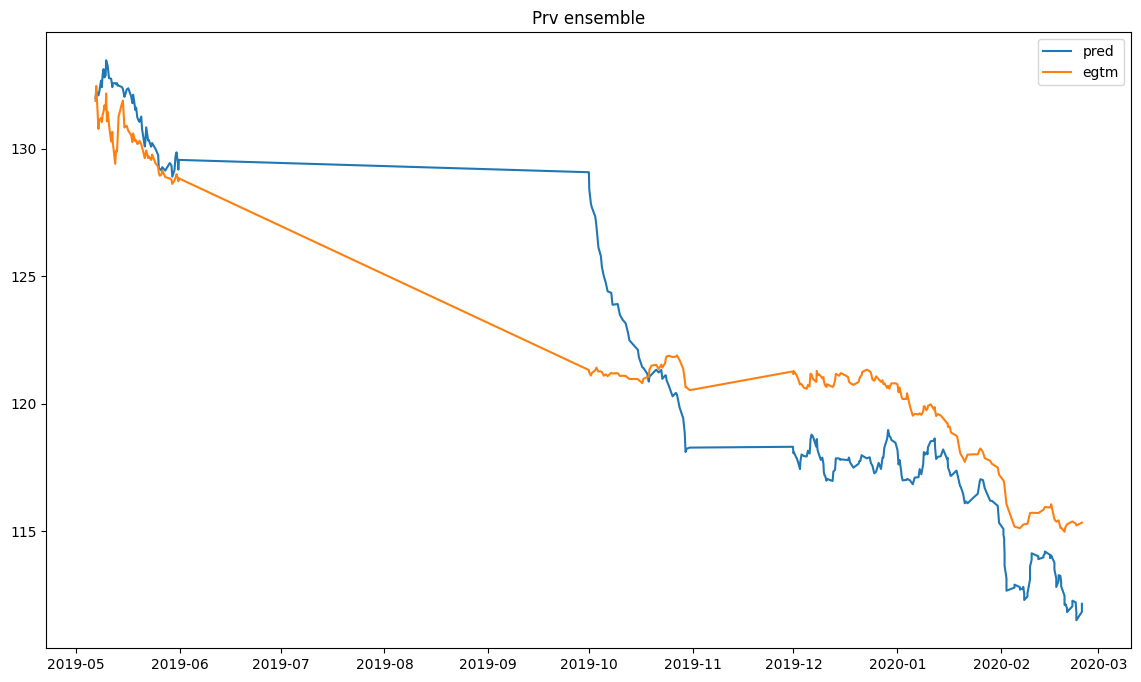

In [46]:
eng = a320_neo_data.query("acnum == 'VP-BWM' and pos == 1").copy()

pred = model.predict(eng, smoothed=True)

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
# plt.scatter(eng['reportts'], smooth(pred['pred'], 0.05), c=eng['egt'], cmap='cool', s=2)
plt.plot(eng['reportts'], pred)
plt.plot(eng['reportts'], eng['egtm'])
plt.legend(['pred', 'egtm'])
plt.show()

In [44]:
pd.DataFrame([{
  "key": k, 
  "coef": v.coef_[0], 
  "intercept": v.intercept_
} for k, v in model.ensemble.items()])

,key,coef,intercept
0,VP-BWB_1,1.231912,84.030628
1,VP-BWB_2,1.172094,75.930223
2,VP-BWM_1,1.501475,71.949059
3,VP-BWM_2,1.281967,89.287981
4,VP-BWN_1,0.316422,111.064488
5,VP-BWN_2,0.449597,99.401559
6,VQ-BCR_1,0.992616,81.548289
7,VQ-BCR_2,0.450519,110.671363
8,VQ-BDQ_1,1.135943,85.015608
9,VQ-BRI_1,0.695996,83.396799


In [ ]:
window = 100

eng = a321_neo_data.query("acnum == 'VQ-BGU'").copy()

for i in range(0, 1000):
  model = EGTMarginRegressor(
    bleed_config=['prv'], 
    # alt_config=[(0, 3400), (3400, 20_000)],
    x_param=x_param, 
    y_param=y_param,
    theta_param=theta_param,
  )

  train = take_early_cycles(eng, i, i + window)
  X = train.drop(columns=['egtm'])
  y = train['egtm']
  model.fit(X, y)
  r2 = model.score(eng, eng['egtm'], smoothed=True)
  
  if r2 > 0.9:
    print(f"R2 score = {r2}; i = {i}")


In [1]:
model = EGTMarginRegressor(
  bleed_config=['prv'], 
  # alt_config=[(0, 3400), (3400, 20_000)],
  x_param=x_param, 
  y_param=y_param,
  theta_param=theta_param,
  mock_linreg=True
)

neo = neo_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()

train = take_early_cycles(neo, 0, 200)
X = train.drop(columns=['egtm'])
y = train['egtm']

model.fit(X, y)

print("R2 score = ", model.score(neo, neo['egtm']))

neo_bcr = neo.query('acnum == "VQ-BRI" and pos == 2').copy()
train_bcr = train.query('acnum == "VQ-BRI" and pos == 2').copy()
pred = model.predict(neo_bcr)

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
plt.plot(neo_bcr['reportts'], smooth(pred, 0.05))
plt.plot(neo_bcr['reportts'], neo_bcr['egtm'])
plt.plot(train_bcr['reportts'], train_bcr['egtm'])
plt.scatter(neo_bcr['reportts'], pred, s=1)
plt.legend(['pred', 'egtm_test', 'egtm_train'])
plt.show()

NameError: name 'EGTMarginRegressor' is not defined

In [113]:
model.ensemble['VP-BWB_1'].coef_, model.ensemble['VP-BWB_1'].intercept_

(array([1.1228012]), 86.0817564)

In [109]:
pd.DataFrame([{
  "key": k, 
  "coef": v.coef_[0], 
  "intercept": v.intercept_
} for k, v in model.ensemble.items()]) \
  .drop(columns=['key']) \
  .mean()

coef          1.122801
intercept    86.081756
dtype: float64

ACMS Baselines:

In [7]:
bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()
acms_bgu = acms_full.query(f"acnum == 'VQ-BGU' and pos == 2 and n1a_peak > 0 and egt_peak > 0 and tat_peak > -100").copy()
acms_bdu = acms_full.query(f"acnum == 'VQ-BDU' and pos == 2 and n1a_peak > 0 and egt_peak > 0 and tat_peak > -100").copy()

In [8]:
model.ensemble.coef_, model.ensemble.intercept_

(array([1.3774313]), -16.026504757493342)

In [9]:
acms_bgu.shape

(3287, 204)

/tmp/ipykernel_1291767/682793783.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (0 + theta ** alpha2)
/tmp/ipykernel_1291767/682793783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)


Split size:  (True,) 343
Split size:  (False,) 57
R2 score =  0.9103522386232006


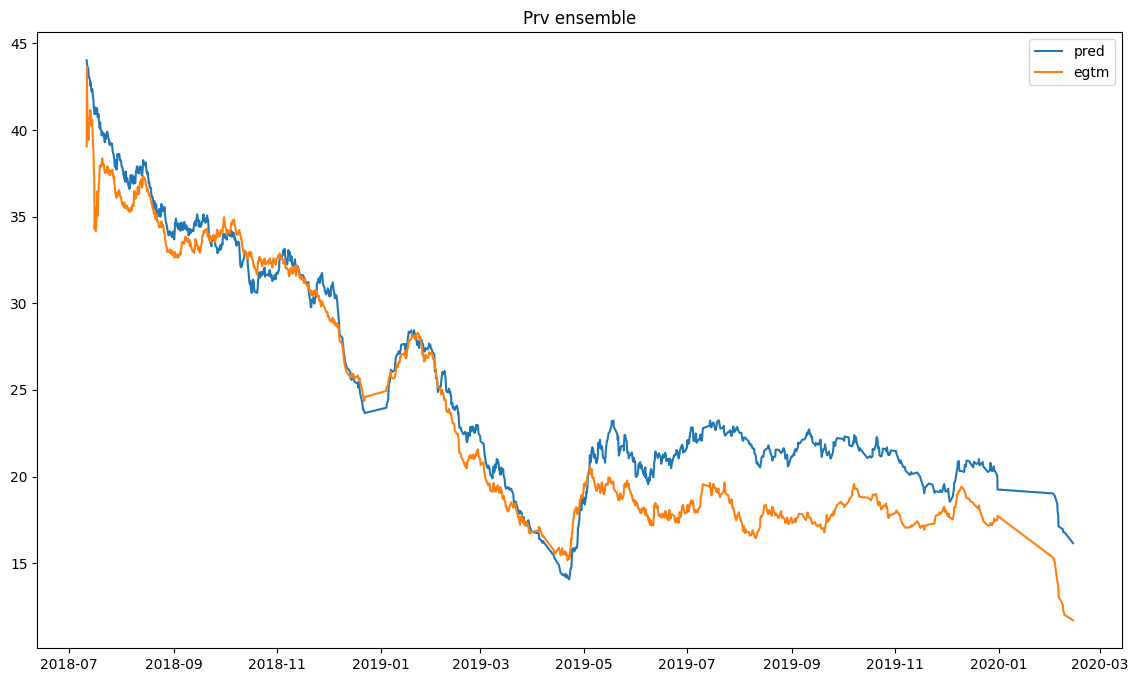

In [10]:
model = EGTMarginRegressor(
  acms_data=acms_bdu[:800], 
  bleed_config=['prv'], 
  x_param='n1a_peak', 
  y_param='egt_peak',
)

train = bdu[200:600]
X = train
y = train['egtm']

model.fit(X, y)

pred = model.predict(bdu)

print("R2 score = ", model.score(bdu, bdu['egtm']))

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
plt.plot(bdu['reportts'], smooth(pred['pred'], 0.05))
plt.plot(bdu['reportts'], bdu['egtm'])
plt.legend(['pred', 'egtm'])
plt.show()

### 1. Gridsearch of x/y/theta variants

Use proper gridsearch utilizing new regressor class

In [117]:
from sklearn.model_selection import GridSearchCV

best_r2 = -1000
best_model = None
best_pred = None
best_x, best_y, best_th = None, None, None

x_variants = [\
  'n1', 'n1a', 'n1com', 'n1c2', 'n2a', 'n2c5',
  'n2p', 'nf', 'n1_peak', 'n1msa', 'n1p',
  'n1a_peak', 'n1c2_peak', 'n1com_peak', 
  'n1max', 'n1max_peak', 'n2a_peak', 'nf_peak']

y_variants = ['egt', 'egt_peak', 'egtb']

theta_variants = ['oat', 'oat_peak', 't14', 't2', 't25', 't2_peak', 'tat', 'tat_rtd', 'tn', 'tat_peak']

hall_of_fame = []

tat_peak = правильный

In [ ]:
model = EGTMarginRegressor()

train = bgu.copy()
X = train.drop(columns=['egtm'])
y = train['egtm']


grid = GridSearchCV(model, {
  'x_param': x_variants,
  'y_param': y_variants,
  'theta_param': theta_variants
}, n_jobs=-1)

grid.fit(X, y)

In [13]:
grid.best_params_

{'theta_param': 't2', 'x_param': 'n1', 'y_param': 'egt'}

In [14]:
cv_results = grid.cv_results_

params = cv_results['params']
mean_scores = cv_results['mean_test_score']

param_scores = list(zip(params, mean_scores))

# Sort parameter combinations based on scores
sorted_param_scores = sorted(param_scores, key=lambda x: x[1], reverse=True)

# Get the top n parameter combinations
n = 5  # Specify the number of top parameter combinations you want
top_n_param_combinations = sorted_param_scores[:n]

# Print the top n parameter combinations
print(f"Top {n} parameter combinations:")
for i, (params, score) in enumerate(top_n_param_combinations, start=1):
    print(f"{i}. Parameters: {params}, Mean Test Score: {score}")

Top 5 parameter combinations:
1. Parameters: {'theta_param': 't2', 'x_param': 'n1', 'y_param': 'egt'}, Mean Test Score: -1.1280445361125069
2. Parameters: {'theta_param': 'oat', 'x_param': 'nf', 'y_param': 'egt'}, Mean Test Score: -1.166528498321337
3. Parameters: {'theta_param': 't2', 'x_param': 'nf', 'y_param': 'egt'}, Mean Test Score: -1.1695969205695327
4. Parameters: {'theta_param': 'oat', 'x_param': 'n1', 'y_param': 'egt'}, Mean Test Score: -1.1938117277852076
5. Parameters: {'theta_param': 'oat', 'x_param': 'n1a', 'y_param': 'egt'}, Mean Test Score: -1.2234371005190883


In [118]:
from sklearn.linear_model import LinearRegression

for x_param in x_variants:
  for y_param in y_variants:
    for theta_param in theta_variants:
      neo_filtered = a321_neo_data.query(f"{x_param} >= 0 and {y_param} >= 0 and {theta_param} > -100 and egtm > -100").copy()
      train = take_early_cycles(neo_filtered, 8, 108)
      X = train.drop(columns=['egtm'])
      y = train['egtm']

      model = EGTMarginRegressor(
        bleed_config=['prv'], 
        x_param=x_param, 
        y_param=y_param,
        theta_param=theta_param,
      )

      model.fit(X, y)

      r2 = model.score(neo_filtered, neo_filtered['egtm'], smoothed=True)
      
      if r2 > best_r2:
        best_pred = pred
        best_r2 = r2
        best_model = model
        best_x, best_y, best_th = x_param, y_param, theta_param

      hall_of_fame.append({
        'x_param': x_param,
        'y_param': y_param, 
        'theta_param': theta_param,
        'r2': r2
      })


In [121]:
pd.DataFrame(hall_of_fame).sort_values('r2', ascending=False)[:10]

,x_param,y_param,theta_param,r2
491,n2a_peak,egt_peak,oat_peak,0.848955
492,n2a_peak,egt_peak,t14,0.835381
259,n1_peak,egt_peak,tat_peak,0.835250
349,n1a_peak,egt_peak,tat_peak,0.822926
495,n2a_peak,egt_peak,t2_peak,0.820482
252,n1_peak,egt_peak,t14,0.816900
499,n2a_peak,egt_peak,tat_peak,0.815789
342,n1a_peak,egt_peak,t14,0.805045
251,n1_peak,egt_peak,oat_peak,0.799104
255,n1_peak,egt_peak,t2_peak,0.792395


#### Plot best result: 

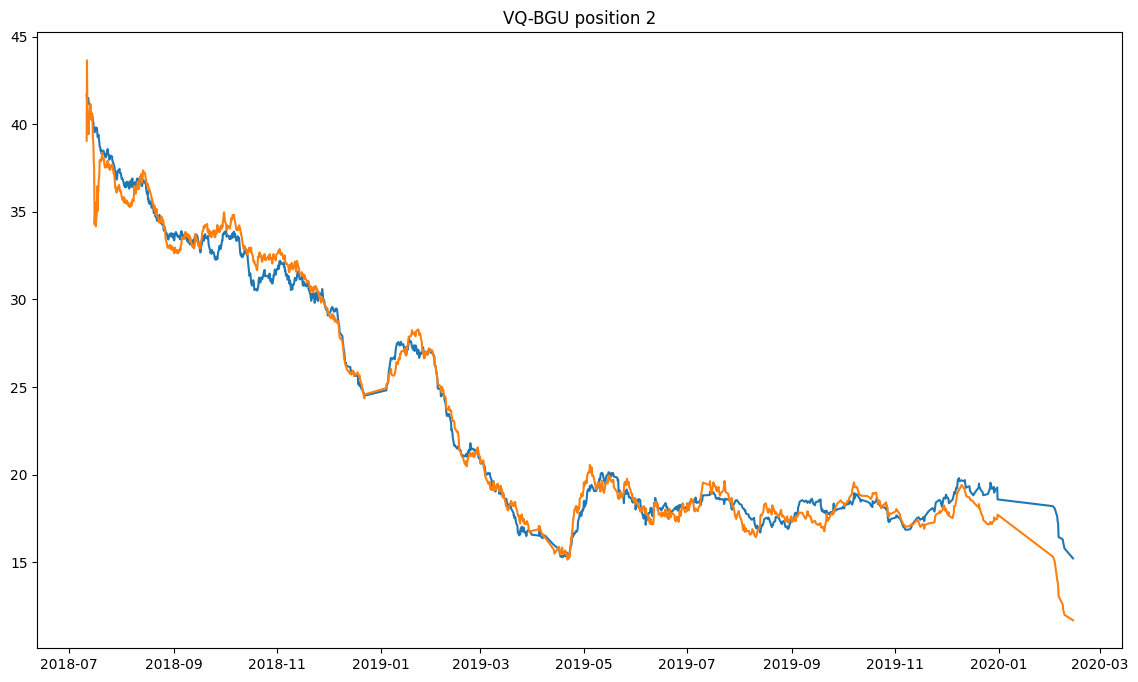

In [17]:
import matplotlib.pyplot as plt

bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
plt.plot(bdu['reportts'], best_pred)
plt.plot(bdu['reportts'], bdu['egtm'])
plt.show()

### Finetune coefficient for theta corrections

In [18]:
best_x, best_y, best_th

('n2a_peak', 'egt_peak', 't14')

In [19]:
best_rmse = 1000
best_a = 1000

factor = 10_000

for a in range(8000, 9000, 1):
  bdu = theta_correct(bdu, best_x, best_y, best_th, alpha2=(a / factor))
  x_param_k, y_param_k = f'{best_x}_k', f'{best_y}_k'
  baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
  egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

  X = pd.DataFrame(smooth(egtm, 0.05))
  lin_model = LinearRegression()
  lin_model.fit(X, y=bdu['egtm'])

  pred = lin_model.predict(X)
  
  rmse = root_mean_squared_error(bdu['egtm'], pred)

  if rmse < best_rmse:
    best_a = a / factor
    best_rmse = rmse

print(best_a, best_rmse)

0.8825 0.8315689377080188


**Result For VQ-BDU pos 2:**

```
- alpha_2 ~ 0.869
- x_param = n2a_peak
- y_param = egt_peak	
- theta_param = tat
```

For VQ-BGU results are inconsistent; We try to plot deltas applying corrections same as for VQ-BDU

In [20]:
bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2 and reportts >= "2019-01-01"')
bgu_all.shape

(814, 212)

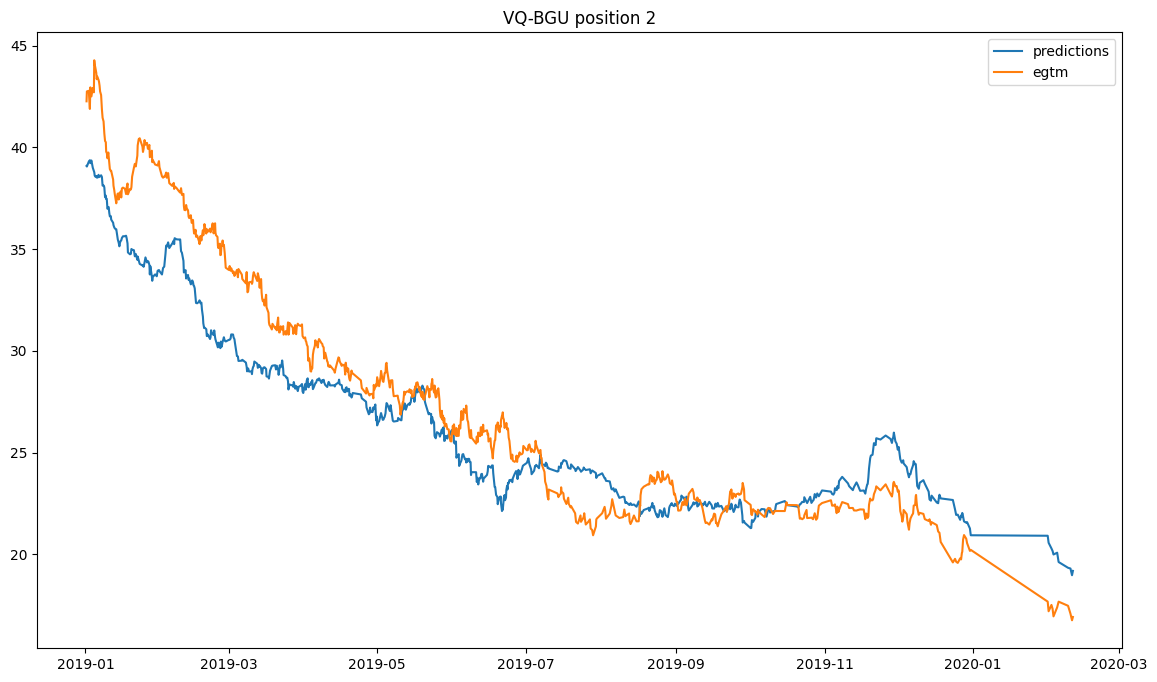

In [21]:
x_param = "n2a_peak"
y_param = "egt_peak"
theta_param = "tat_peak"

bgu = bgu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
bgu = theta_correct(bgu, x_param, y_param, theta_param)
assert bgu.shape[0] >= 100
baseline = train_engine_baseline(bgu[:100], x_param_k, y_param_k)
egtm = compute_egtm(bgu, baseline, x_param_k, y_param_k)

X = pd.DataFrame(smooth(egtm, 0.05))
lin_model = LinearRegression()
lin_model.fit(X[:100], y=bgu['egtm'][:100])

pred = lin_model.predict(X)

rmse = root_mean_squared_error(bgu['egtm'], pred)

# bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
# plt.plot(bgu['reportts'], pred)
plt.plot(bgu['reportts'], smooth(0.8 * egtm + 7.4, 0.05))
plt.plot(bgu['reportts'], bgu['egtm'])
plt.legend(['predictions', 'egtm'])
plt.show()